In [184]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
#import torch.optim as optim

import pandas as pd
import seaborn as sns


In [185]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [186]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [187]:
class Blur(nn.Module):
    def __init__(self):
        super(Blur, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.MaxPool2d(4)
        )

    def forward(self,x):
       x = self.layers(x)
       #print(x.shape)
       x = F.interpolate(x, size=(32, 32), mode='nearest')
       return x


def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  #plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  #plt.show()

im, label = trainset[0]

effect = Blur()
#imshow(im)
im = torch.unsqueeze(im, 0)


blurredim = effect(im)
#print(blurredim.shape)
#imshow(torch.squeeze(blurredim))


In [188]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.00)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ConvLayers = torch.nn.Sequential(
            nn.Conv2d(3, 96, 3, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),
            
            nn.Conv2d(96, 192, 3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),

            nn.Conv2d(192, 192, 3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),

            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),

            nn.Conv2d(192, 192, 3, stride=2, padding =1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),

            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),

            nn.Conv2d(192, 192, 1),
            nn.ReLU(),
            nn.Conv2d(192, 10, 1),
            nn.AvgPool2d(2),
    
            #PrintLayer(),
            #Using Cross entropy loss so don't
            #need to apply softmax to output of last layer
        )

        #self.fc1 = nn.Linear(160, 80)
        self.fc2 = nn.Linear(40, 10)

    

    def forward(self, x):
        x = self.ConvLayers(x)
        x = torch.flatten(x, start_dim=1)
        #x = self.fc1(x)
        x = self.fc2(x)
        return x
    

model = CNN()
model.apply(init_weights)
print("bruh")

bruh


In [189]:
print_output_shape = False


data_iter = iter(trainset)

for i in range(3):
    (data, label) = next(data_iter)
im = data
data = data.unsqueeze(0)
input_shape = data.shape

if (print_output_shape):
    print(data.shape)
    print('\n')


from torchsummary import summary
_ = summary(model, (3, 32, 32))

#print(model(data).shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 96, 32, 32]          2,688
|    └─ReLU: 2-2                         [-1, 96, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 192, 16, 16]         166,080
|    └─ReLU: 2-4                         [-1, 192, 16, 16]         --
|    └─Conv2d: 2-5                       [-1, 192, 8, 8]           331,968
|    └─ReLU: 2-6                         [-1, 192, 8, 8]           --
|    └─Conv2d: 2-7                       [-1, 192, 8, 8]           331,968
|    └─ReLU: 2-8                         [-1, 192, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 192, 4, 4]           331,968
|    └─ReLU: 2-10                        [-1, 192, 4, 4]           --
|    └─Conv2d: 2-11                      [-1, 192, 4, 4]           331,968
|    └─ReLU: 2-12                        [-1, 192, 4, 4] 

In [190]:
epoch_list = []
minibatch_number_list = []
loss_list = []

In [191]:
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.97)


In [192]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0


    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
       
        outputs = model(inputs)
        #print(outputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 60 mini-batches
            epoch_list.append(epoch+1)
            minibatch_number_list.append(i+1)
            loss_list.append(running_loss/40)

            
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}')
            running_loss = 0.0
            #print(scheduler.get_last_lr())


    scheduler.step()

print('Finished Training')

[1,    40] loss: 2.303
[1,    80] loss: 2.303
[1,   120] loss: 2.303
[1,   160] loss: 2.303
[1,   200] loss: 2.303
[1,   240] loss: 2.303
[1,   280] loss: 2.303
[1,   320] loss: 2.303
[1,   360] loss: 2.303
[2,    40] loss: 2.303
[2,    80] loss: 2.302
[2,   120] loss: 2.303
[2,   160] loss: 2.303
[2,   200] loss: 2.303
[2,   240] loss: 2.303
[2,   280] loss: 2.303
[2,   320] loss: 2.302
[2,   360] loss: 2.303
[3,    40] loss: 2.302
[3,    80] loss: 2.303
[3,   120] loss: 2.302
[3,   160] loss: 2.303
[3,   200] loss: 2.302
[3,   240] loss: 2.302
[3,   280] loss: 2.302
[3,   320] loss: 2.302
[3,   360] loss: 2.302
[4,    40] loss: 2.302
[4,    80] loss: 2.301
[4,   120] loss: 2.301
[4,   160] loss: 2.301
[4,   200] loss: 2.300
[4,   240] loss: 2.300
[4,   280] loss: 2.299
[4,   320] loss: 2.297
[4,   360] loss: 2.295
[5,    40] loss: 2.281
[5,    80] loss: 2.255
[5,   120] loss: 2.191
[5,   160] loss: 2.145
[5,   200] loss: 2.103
[5,   240] loss: 2.084
[5,   280] loss: 2.068
[5,   320] 

KeyboardInterrupt: 

Text(0, 0.5, 'Avg Cross Entropy Loss|')

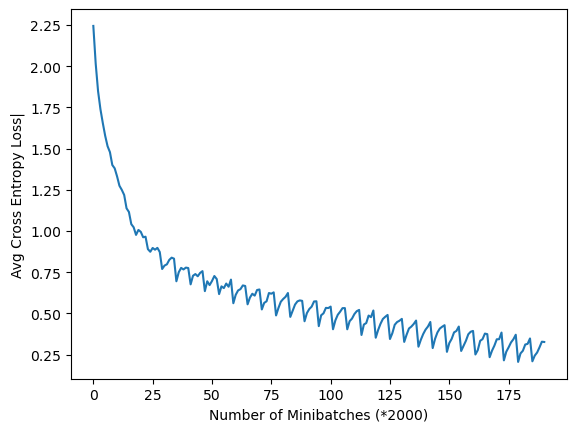

In [ ]:
dic = {'losses':loss_list, 'epoch':epoch_list, "batch":minibatch_number_list}
df = pd.DataFrame(data=dic)

p = sns.lineplot(data=df, x=df.index, y='losses')
p.set_xlabel("Number of Minibatches (*2000)")
p.set_ylabel("Avg Cross Entropy Loss|")

In [ ]:
test_single_image = False

if (test_single_image == True):
    data_iter = iter(testset)

    for i in range(40):
        (data, label) = next(data_iter)
    im = data
    data = data.unsqueeze(0)
    soft = nn.Softmax(dim=1)
    imshow(im)
    print(label)

    model_output = model(data)
    prediction = soft(model_output)

    _, ind = (torch.max(prediction, dim=1))
    print(ind)
    print("\n")



#from torchviz import make_dot, make_dot_from_trace
#make_dot(model_output.mean(), params=dict(model.named_parameters()))




In [ ]:

running_samples_total = 0
correct_predictions_total = 0

for indx, data in enumerate(testloader):
    inputs, labels = data
    prediction = model(inputs)
    _, tensor_index = torch.max(prediction, dim=1)

    
    correct_predictions_total += (len(labels[labels==tensor_index]))
    running_samples_total += batch_size
    
    #if (indx >= 2):
    #    break

print (correct_predictions_total)
print(f"#Samples: {running_samples_total}     #Correct Predctions: {correct_predictions_total}      Accuracy:{correct_predictions_total/running_samples_total}")

7745
#Samples: 10000     #Correct Predctions: 7745      Accuracy:0.7745


### Code to save Model

In [ ]:
#torch.save(model.state_dict(), "model_weights_v2")

In [ ]:
print(len(trainset))
print(len(testset))

50000
10000
